In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import glob
import seaborn as sns
from scipy.stats import norm
import matplotlib.gridspec as gridspec

sys.path.append('../funcs')

import proteomics as prot
import processing as pp
import plotting as pl
from utils import get_pcs, remove_covariates, plot_pca, plot_pca_gridplot, plot_pca_ax

import warnings
warnings.filterwarnings('ignore')

/home/sanand/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
DATA_DIR = "../data/raw/proteomics/"
OUT_DIR = "../data/processed/061721/per_cohort_matrices"
PLOTS_DIR = "figures/data_processing_per_cohort"
MAPPING_FILE = "../data/processed/061721/PanCan_Participant_freeze_mapping.tsv"
SUBSET_LOCALIZED_SITES = False
KNN_NEIGHBORS = 5

In [3]:
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

os.makedirs(os.path.join(OUT_DIR, "nafilt"), exist_ok=True)
os.makedirs(os.path.join(OUT_DIR, "imputed"), exist_ok=True)
os.makedirs(os.path.join(OUT_DIR, "imputed_inv"), exist_ok=True)

## 1. Loading Info from Raw `.gct` Files

`accessionNumber_VMsites_numVMsitesPresent_numVMsitesLocalizedBest_earliestVMsiteAA_latestVMsiteAA`

---

In [4]:
gct = {}

for x in glob.glob(os.path.join(DATA_DIR,'*')):
    if os.path.isdir(x):
        cohort = os.path.basename(x).upper()
        cohort_gct = {}
        print("   * Loading {} ...".format(cohort))
        
        for filepath in glob.glob(os.path.join(x,"*.gct")):
            g = prot.GCT(filepath)
            
            if SUBSET_LOCALIZED_SITES:
                if g.assay in ('acetylome','phosphoproteome'):
                    _prev = g.n_var
                    feats_to_keep = g.var_names[[x.split("_")[3]==x.split("_")[4] for x in g.var_names]]
                    g.subset(var=feats_to_keep)
                    print("     * {} | {}/{} ({:,.2f}%) fully localized sites".format(g.assay, g.n_var, _prev, 100*g.n_var/_prev))
                
            cohort_gct[g.assay] = g
 
        gct[cohort] = cohort_gct

   * Loading COAD ...
   * Loading MEDUL ...
   * Loading UCEC ...
   * Loading LUAD ...
   * Loading HNSCC ...
   * Loading PDAC ...
   * Loading CCRCC ...
   * Loading BRCA ...
   * Loading GBM ...
   * Loading OV ...
   * Loading LSCC ...


In [5]:
prot.parse_participant_and_type(gct,'proteome')
prot.parse_participant_and_type(gct,'phosphoproteome')
prot.parse_participant_and_type(gct,'acetylome')

In [6]:
prot_df = pd.concat([gct[cohort]['proteome'].obs for cohort in gct.keys()])
phosph_df = pd.concat([gct[cohort]['phosphoproteome'].obs for cohort in gct.keys()])
acetyl_df = pd.concat([gct[cohort]['acetylome'].obs for cohort in ['BRCA','GBM','LSCC','LUAD','UCEC','MEDUL']])

## 2. Load Participant Dataframe


Curated by Yo Akiyama.

---

In [7]:
samples_df = pd.read_csv(MAPPING_FILE,sep='\t',index_col=0)
samples_df.head()

,cohort,Proteome_Sample_ID,Proteome_Normal_Sample_ID,Phosphoproteome_Sample_ID,Phosphoproteome_Normal_Sample_ID,Acetylome_Sample_ID,Acetylome_Normal_Sample_ID,RNA_Tumor,RNA_Normal,Germline_WGS,WXS
participant_id,,,,,,,,,,,
CPT000814,BRCA,CPT000814,NaN,CPT000814,NaN,CPT000814,NaN,334_R,NaN,NaN,604_T
CPT001846,BRCA,CPT001846,NaN,CPT001846,NaN,CPT001846,NaN,340_R,NaN,NaN,01BR044_T
01BR001,BRCA,X01BR001,NaN,X01BR001,NaN,X01BR001,NaN,25-R,NaN,NaN,01BR001_T
01BR008,BRCA,X01BR008,NaN,X01BR008,NaN,X01BR008,NaN,350-R,NaN,NaN,01BR008_T
01BR009,BRCA,X01BR009,NaN,X01BR009,NaN,X01BR009,NaN,345-R,NaN,NaN,01BR009_T


In [8]:
prot_df.to_csv(os.path.join(OUT_DIR, "proteome_obs.tsv"),sep='\t')
phosph_df.to_csv(os.path.join(OUT_DIR, "phosphoproteome_obs.tsv"),sep='\t')
acetyl_df.to_csv(os.path.join(OUT_DIR, "acetylome_obs.tsv"),sep='\t')

## 3. Combine Matrices
---

In [9]:
def get_samples(samples_df, cohort, col):
    return samples_df[samples_df['cohort']==cohort][col].dropna()

In [10]:
assays = ('proteome','phosphoproteome','acetylome')

raw_data_files = {}
n_feats = {}
features_df = list()

for assay in assays:
    raw_data_files[assay] = {}
    n_feats[assay] = {}
    
    for cohort in gct.keys():
        if assay in gct[cohort]:
            raw_data_files[assay][cohort] = {}
            
            # Tumor
            raw_data_files[assay][cohort]['Tumor'] = gct[cohort][assay].X[
                get_samples(samples_df, cohort, '{}_Sample_ID'.format(assay.capitalize()))
            ].dropna(axis=0,how='all').copy()
            
            # Normal
            raw_data_files[assay][cohort]['Normal'] = gct[cohort][assay].X[
                get_samples(samples_df, cohort, '{}_Normal_Sample_ID'.format(assay.capitalize()))
            ].dropna(axis=0,how='all').copy()
            
            # All
            all_samples = list(get_samples(samples_df, cohort, '{}_Sample_ID'.format(assay.capitalize())).values)+list(get_samples(samples_df, cohort, '{}_Normal_Sample_ID'.format(assay.capitalize())).values)
            raw_data_files[assay][cohort]['All'] =  gct[cohort][assay].X[all_samples].dropna(axis=0, how='all').copy()
            
            # Stats
            n_feats[assay][cohort] = {}
            n_feats[assay][cohort]['Tumor'] = {}
            n_feats[assay][cohort]['Normal'] = {}

            n_feats[assay][cohort]['Tumor']['coverage'] = raw_data_files[assay][cohort]['Tumor'].shape[0]
            n_feats[assay][cohort]['Tumor']['samples'] = raw_data_files[assay][cohort]['Tumor'].shape[1]
            n_feats[assay][cohort]['Normal']['coverage'] = raw_data_files[assay][cohort]['Normal'].shape[0]
            n_feats[assay][cohort]['Normal']['samples'] = raw_data_files[assay][cohort]['Normal'].shape[1]
            
            # Features
            feats_df = pd.DataFrame(raw_data_files[assay][cohort]['Tumor'].index).rename(columns={'id':assay})
            feats_df['type'] = 'Tumor'
            feats_df['cohort'] = cohort
            features_df.append(feats_df)
            
            feats_df = pd.DataFrame(raw_data_files[assay][cohort]['Normal'].index).rename(columns={'id':assay})
            feats_df['type'] = 'Normal'
            feats_df['cohort'] = cohort
            features_df.append(feats_df)
            
features_df = pd.concat(features_df)

In [11]:
n_feats = pd.DataFrame.from_dict(n_feats)
full_feats_df = list()

for col in n_feats.columns:
    for row in n_feats.index:
        try:
            _df = pd.DataFrame.from_dict(n_feats.loc[row,col]).T.reset_index().rename(columns={'index':'Type'})
            _df['Assay'] = col
            _df['Cohort'] = row
            full_feats_df.append(_df)
        except:
            pass
        
full_feats_df = pd.concat(full_feats_df)

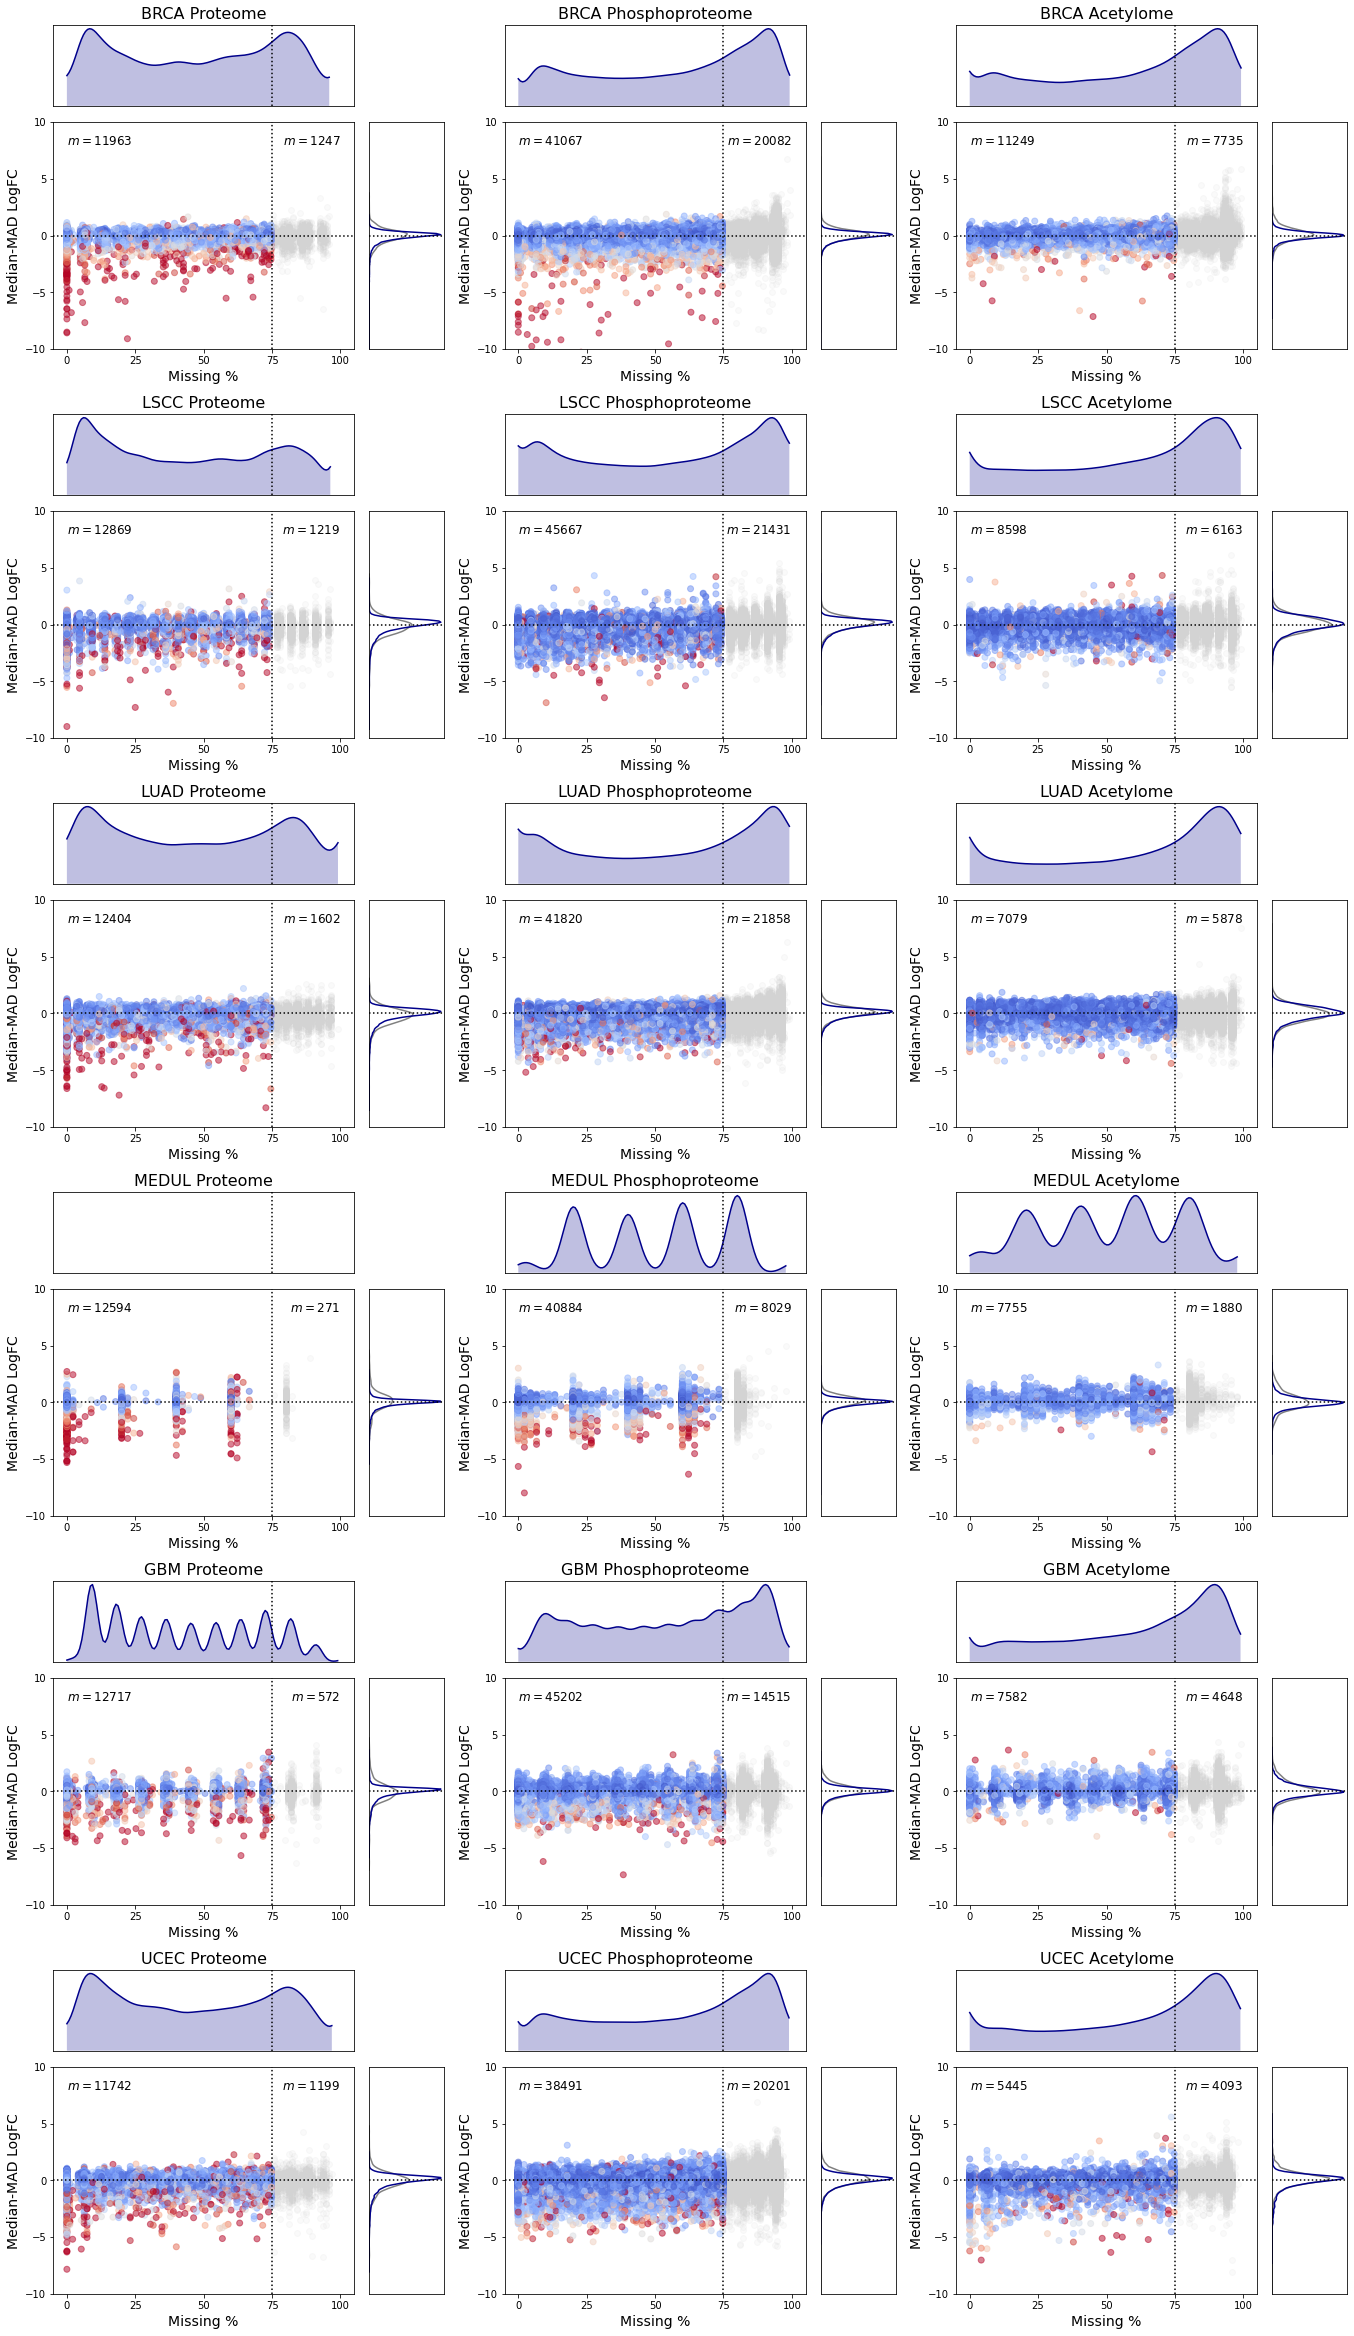

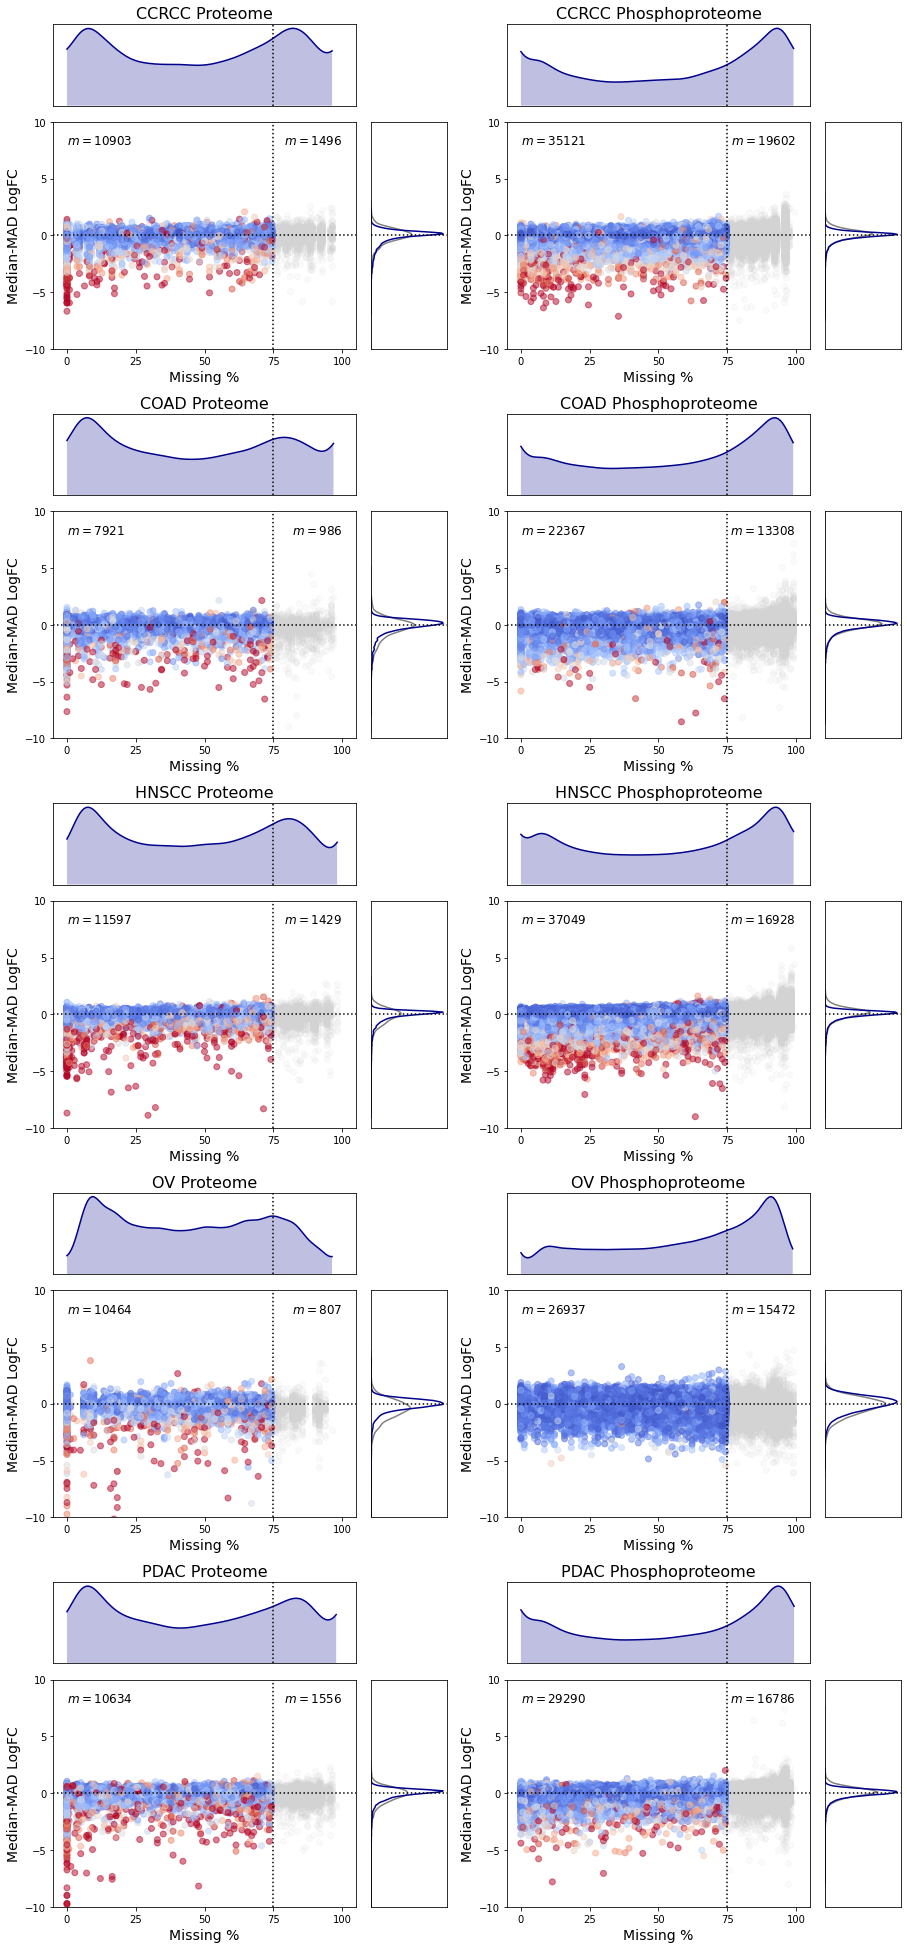

In [12]:
_aggr_1_df = pl.plot_prot_grid_qc(
    raw_data_files,
    np.array(['BRCA','LSCC','LUAD','MEDUL','GBM','UCEC']),
    ['proteome','phosphoproteome','acetylome'],
    (0.75,0.75,0.75)
)
plt.savefig(os.path.join(PLOTS_DIR, "raw_tumor_grid_qc_1.pdf"), dpi=100, bbox_inches='tight')

_aggr_2_df = pl.plot_prot_grid_qc(
    raw_data_files,
    np.array(['CCRCC','COAD','HNSCC','OV','PDAC']),
    ['proteome','phosphoproteome'],
    (0.75,0.75,0.75)
)
plt.savefig(os.path.join(PLOTS_DIR, "raw_tumor_grid_qc_2.pdf"), dpi=100, bbox_inches='tight')

In [13]:
_aggr_1_df += _aggr_2_df
aggr_df = pd.concat(_aggr_1_df)

In [14]:
X_filt = dict()

for cohort in np.unique(samples_df['cohort']):
    X_filt[cohort] = dict()
    
    if cohort in ['BRCA','LSCC','LUAD','MEDUL','GBM','UCEC']:
        for assay in assays:
            sites = aggr_df[
                (aggr_df['assay']==assay) & 
                (aggr_df['cohort']==cohort) & 
                (aggr_df['keep'])
            ].index
            
            X_filt[cohort][assay] = raw_data_files[assay][cohort]['All'].loc[sites].T
    else:
        for assay in ('proteome','phosphoproteome'):
            sites = aggr_df[
                (aggr_df['assay']==assay) & 
                (aggr_df['cohort']==cohort) & 
                (aggr_df['keep'])
            ].index
            
            X_filt[cohort][assay] = raw_data_files[assay][cohort]['All'].loc[sites].T

In [15]:
def save_matrices(X, out_dir):
    """
    Save matrices function.
    """
    os.makedirs(out_dir, exist_ok=True)
    
    for cohort in X.keys():
        X[cohort]['proteome'] = X[cohort]['proteome'].astype(float)
        X[cohort]['phosphoproteome'] = X[cohort]['phosphoproteome'].astype(float)
        
        X[cohort]['proteome'].T.to_parquet(os.path.join(out_dir, "{}_proteome_X.parquet".format(cohort)))
        X[cohort]['phosphoproteome'].T.to_parquet(os.path.join(out_dir, "{}_phosphoproteome_X.parquet".format(cohort)))

        try:
            X[cohort]['acetylome'] = X[cohort]['acetylome'].astype(float)
            X[cohort]['acetylome'].T.to_parquet(os.path.join(out_dir, "{}_acetylome_X.parquet".format(cohort)))
        except:
            pass

In [16]:
save_matrices(X_filt, os.path.join(OUT_DIR, "nafilt"))

## 4. Impute within Each Dataset

---

In [17]:
from sklearn.impute import KNNImputer

X_filt_i = {}

for cohort in np.unique(samples_df['cohort']):
    print("Imputing in {}...".format(cohort))
    X_filt_i[cohort] = dict()
    
    if cohort in ['BRCA','LSCC','LUAD','MEDUL','GBM','UCEC']:
        for assay in assays:
            imputer = KNNImputer(n_neighbors=KNN_NEIGHBORS)
            X_filt_i[cohort][assay] = pd.DataFrame(
                imputer.fit_transform(X_filt[cohort][assay]), 
                index=X_filt[cohort][assay].index, 
                columns=X_filt[cohort][assay].columns
            )
    else:
        for assay in ('proteome','phosphoproteome'):
            imputer = KNNImputer(n_neighbors=KNN_NEIGHBORS)
            X_filt_i[cohort][assay] = pd.DataFrame(
                imputer.fit_transform(X_filt[cohort][assay]), 
                index=X_filt[cohort][assay].index, 
                columns=X_filt[cohort][assay].columns
            )

Imputing in BRCA...
Imputing in CCRCC...
Imputing in COAD...
Imputing in GBM...
Imputing in HNSCC...
Imputing in LSCC...
Imputing in LUAD...
Imputing in MEDUL...
Imputing in OV...
Imputing in PDAC...
Imputing in UCEC...


In [18]:
save_matrices(X_filt_i, os.path.join(OUT_DIR, "imputed"))

## 6. Inverse Normal Transform

---

In [19]:
from qtl.norm import inverse_normal_transform

X_filt_i_inv = {}

for cohort in np.unique(samples_df['cohort']):
    print("Transforming {}...".format(cohort))
    X_filt_i_inv[cohort] = dict()
    
    if cohort in ['BRCA','LSCC','LUAD','MEDUL','GBM','UCEC']:
        for assay in assays:
            X_filt_i_inv[cohort][assay] = inverse_normal_transform(X_filt_i[cohort][assay].T).T
    else:
        for assay in ('proteome','phosphoproteome'):
            X_filt_i_inv[cohort][assay] = inverse_normal_transform(X_filt_i[cohort][assay].T).T

Transforming BRCA...
Transforming CCRCC...
Transforming COAD...
Transforming GBM...
Transforming HNSCC...
Transforming LSCC...
Transforming LUAD...
Transforming MEDUL...
Transforming OV...
Transforming PDAC...
Transforming UCEC...


In [20]:
save_matrices(X_filt_i_inv, os.path.join(OUT_DIR, "imputed_inv"))

## 6. Normalize PTM to Protein Levels

---

In [21]:
meta_s = samples_df[['cohort','Proteome_Sample_ID']].dropna().set_index("Proteome_Sample_ID")['cohort']

In [22]:
def load_matrices(out_dir):
    X = {}
    cohorts = {x.split("_")[0] for x in os.listdir(out_dir)}
    
    for cohort in cohorts:
        X[cohort] = {}
        X[cohort]['proteome'] = pd.read_parquet(os.path.join(out_dir, "{}_proteome_X.parquet".format(cohort))).T
        X[cohort]['phosphoproteome'] = pd.read_parquet(os.path.join(out_dir, "{}_phosphoproteome_X.parquet".format(cohort))).T

        try:
            X[cohort]['acetylome'] = pd.read_parquet(os.path.join(out_dir, "{}_acetylome_X.parquet".format(cohort))).T
        except:
            pass
        
    return X

In [23]:
X_filt_i = load_matrices(os.path.join(OUT_DIR, "imputed"))

In [24]:
os.makedirs(os.path.join(OUT_DIR, "imputed_res"))

In [25]:
X_filt_i_res = {}

for cohort in X_filt_i.keys():
    X_filt_i_res[cohort] = {}
    _df_phospho,_res_phospho = prot.fit_ptm_prot_ols(X_filt_i[cohort]['phosphoproteome'].T, X_filt_i[cohort]['proteome'].T)
    _df_phospho.to_parquet(os.path.join(OUT_DIR, "imputed_res", "{}_phosphoproteome_ols_filt.parquet".format(cohort)))
    
    _df_phospho = pd.pivot(_df_phospho.reset_index()[['id','sample','residual']], index='id',columns='sample',values='residual')
    X_filt_i_res[cohort]['phosphoproteome'] = _df_phospho.T.loc[X_filt_i[cohort]['phosphoproteome'].index]
    
    try:
        _df_acetyl,_res_acetyl = prot.fit_ptm_prot_ols(X_filt_i[cohort]['acetylome'].T, X_filt_i[cohort]['proteome'].T)
        _df_acetyl.to_parquet(os.path.join(OUT_DIR, "imputed_res", "{}_acetylome_ols_filt.parquet".format(cohort)))
        _df_acetyl = pd.pivot(_df_acetyl.reset_index()[['id','sample','residual']], index='id',columns='sample',values='residual')
        X_filt_i_res[cohort]['acetylome'] = _df_acetyl.T.loc[X_filt_i[cohort]['acetylome'].index]
    except:
        pass

   * 15695 / 22367 sites with matching protein
   * 23624 / 29290 sites with matching protein
   * 35350 / 40884 sites with matching protein
   * 6833 / 7755 sites with matching protein
   * 21171 / 26937 sites with matching protein
   * 27994 / 35121 sites with matching protein
   * 34610 / 41067 sites with matching protein
   * 9950 / 11249 sites with matching protein
   * 38658 / 45667 sites with matching protein
   * 7564 / 8598 sites with matching protein
   * 30756 / 37049 sites with matching protein
   * 35282 / 41820 sites with matching protein
   * 6133 / 7079 sites with matching protein
   * 32266 / 38491 sites with matching protein
   * 4684 / 5445 sites with matching protein
   * 39130 / 45202 sites with matching protein
   * 6679 / 7582 sites with matching protein


In [26]:
def save_matrices_ptm(X, out_dir):
    os.makedirs(out_dir, exist_ok=True)
    
    for cohort in X.keys():
        X[cohort]['phosphoproteome'] = X[cohort]['phosphoproteome'].astype(float)
        X[cohort]['phosphoproteome'].T.to_parquet(os.path.join(out_dir, "{}_phosphoproteome_X.parquet".format(cohort)))

        try:
            X[cohort]['acetylome'] = X[cohort]['acetylome'].astype(float)
            X[cohort]['acetylome'].T.to_parquet(os.path.join(out_dir, "{}_acetylome_X.parquet".format(cohort)))
        except:
            pass

In [27]:
save_matrices_ptm(X_filt_i_res, os.path.join(OUT_DIR, "imputed_res"))

## 7. Save .tsv Files

---

In [28]:
for f in glob.glob(os.path.join(OUT_DIR, "nafilt/*.parquet")):
    rename = f.split(".parquet")[0]+".tsv.gz"
    print("Saving {}...".format(rename))
    pd.read_parquet(f).to_csv(rename, sep='\t')

Saving ../data/processed/061721/per_cohort_matrices/nafilt/LUAD_proteome_X.tsv.gz...
Saving ../data/processed/061721/per_cohort_matrices/nafilt/OV_proteome_X.tsv.gz...
Saving ../data/processed/061721/per_cohort_matrices/nafilt/BRCA_acetylome_X.tsv.gz...
Saving ../data/processed/061721/per_cohort_matrices/nafilt/LUAD_acetylome_X.tsv.gz...
Saving ../data/processed/061721/per_cohort_matrices/nafilt/CCRCC_proteome_X.tsv.gz...
Saving ../data/processed/061721/per_cohort_matrices/nafilt/PDAC_phosphoproteome_X.tsv.gz...
Saving ../data/processed/061721/per_cohort_matrices/nafilt/LSCC_phosphoproteome_X.tsv.gz...
Saving ../data/processed/061721/per_cohort_matrices/nafilt/BRCA_proteome_X.tsv.gz...
Saving ../data/processed/061721/per_cohort_matrices/nafilt/MEDUL_proteome_X.tsv.gz...
Saving ../data/processed/061721/per_cohort_matrices/nafilt/HNSCC_proteome_X.tsv.gz...
Saving ../data/processed/061721/per_cohort_matrices/nafilt/UCEC_acetylome_X.tsv.gz...
Saving ../data/processed/061721/per_cohort_matr

In [29]:
for f in glob.glob(os.path.join(OUT_DIR, "imputed/*.parquet")):
    rename = f.split(".parquet")[0]+".tsv.gz"
    print("Saving {}...".format(rename))
    pd.read_parquet(f).to_csv(rename, sep='\t')

Saving ../data/processed/061721/per_cohort_matrices/imputed/LUAD_proteome_X.tsv.gz...
Saving ../data/processed/061721/per_cohort_matrices/imputed/OV_proteome_X.tsv.gz...
Saving ../data/processed/061721/per_cohort_matrices/imputed/BRCA_acetylome_X.tsv.gz...
Saving ../data/processed/061721/per_cohort_matrices/imputed/LUAD_acetylome_X.tsv.gz...
Saving ../data/processed/061721/per_cohort_matrices/imputed/CCRCC_proteome_X.tsv.gz...
Saving ../data/processed/061721/per_cohort_matrices/imputed/PDAC_phosphoproteome_X.tsv.gz...
Saving ../data/processed/061721/per_cohort_matrices/imputed/LSCC_phosphoproteome_X.tsv.gz...
Saving ../data/processed/061721/per_cohort_matrices/imputed/BRCA_proteome_X.tsv.gz...
Saving ../data/processed/061721/per_cohort_matrices/imputed/MEDUL_proteome_X.tsv.gz...
Saving ../data/processed/061721/per_cohort_matrices/imputed/HNSCC_proteome_X.tsv.gz...
Saving ../data/processed/061721/per_cohort_matrices/imputed/UCEC_acetylome_X.tsv.gz...
Saving ../data/processed/061721/per_